# Variation Autoencoders in fastai
### Adaption of https://github.com/pytorch/examples/tree/master/vae to work with fastai

In [ ]:
%matplotlib inline
from fastai.vision import * 
from fastai import *
from torch.autograd import Variable

## Grab the MNIST sample dataset

**Note:** the fastai library currently only supports image classification, so our y values will be the classes of the 
MNIST images. However, we'll just ignore the y values set by fastai here and instead include the original image as part of the output of our model. This has the added advantage that we can make use of fastai's data augmentation techniques as well!


In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)

## Define out model

In [ ]:
class VAE(nn.Module):
    def __init__(self, zdims):
        super(VAE, self).__init__()
        
        self.zdims = 20
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, zdims)
        self.fc22 = nn.Linear(400, zdims)
        self.fc3 = nn.Linear(zdims, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        """
        outputs the reconstructed image, the image we trained on, mu, and log(variance)
        """
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), x, mu, logvar

## Loss Function

See https://github.com/pytorch/examples/blob/master/vae/main.py  for a deeper explanation of the loss function.

fastai will take all of our outputs from our model's `forward` method and pass it as a tuple into the first argument of our loss function.  As noted above, we'll ignore the y values, as we don't care about the labels for our images

In [ ]:
def loss_function(out, _) -> Variable:
    recon_x, x, mu, logvar = out
    batch_size = x.shape[0]
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= batch_size * 784
    return BCE + KLD

In [ ]:
vae = VAE(20)

In [ ]:
learn = Learner(data, vae, loss_func=loss_function)

In [ ]:
learn.fit(10)

Total time: 00:27
epoch  train_loss  valid_loss
1      0.196566    0.186746    (00:02)
2      0.179038    0.173951    (00:02)
3      0.171522    0.169113    (00:02)
4      0.169041    0.166268    (00:02)
5      0.166219    0.165584    (00:02)
6      0.165616    0.164444    (00:02)
7      0.164781    0.163765    (00:02)
8      0.163487    0.162520    (00:02)
9      0.162315    0.161844    (00:02)
10     0.162938    0.161012    (00:02)



In [ ]:
itera = iter(data.valid_dl)

In [ ]:
valid_batch, _ = next(itera)
valid_batch = valid_batch[0].unsqueeze(0).cpu()

In [ ]:
orig_img = Image(valid_batch[0])

In [ ]:
with torch.no_grad():
    d = Variable(valid_batch).cuda()
    recon_batch, mu, logvar, original = vae(d)
    recon_batch = recon_batch.view(-1,3,28,28).cpu()

In [ ]:
recon_img = Image(recon_batch[0])

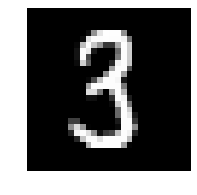

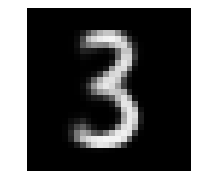

In [ ]:
show_image(orig_img)
show_image(recon_img)